Importing the Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
plt.figure(figsize = (6,5))

<Figure size 432x360 with 0 Axes>

<Figure size 432x360 with 0 Axes>

Reading the Data

In [ ]:
df=pd.read_csv('/content/drug200.csv')

In [ ]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


#Data Exploration

Treating Missing Values

In [ ]:
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [ ]:
df.shape

(200, 6)

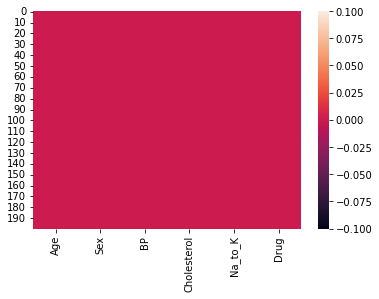

In [ ]:
sns.heatmap(df.isnull())

from the above result there is no missing value

Dividing into categorical and numerical values for data exploration

1.Numerical variable

In [ ]:
num_col=[col for col in df.columns if df[col].dtypes!='O' ]

In [ ]:
num_col

['Age', 'Na_to_K']

In [ ]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


We are now finding the skewness value for each numerical variable

skewness:  0.03030835703000607


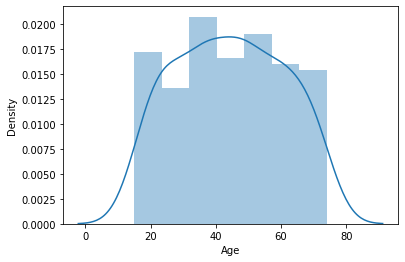

skewness:  1.039341186028881


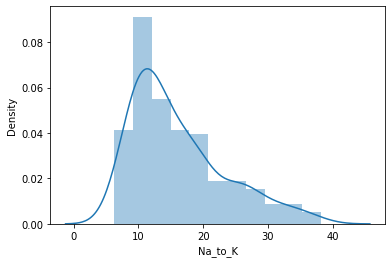

In [ ]:
for col in num_col:
  skew = df[col].skew(axis = 0, skipna = True)
  print('skewness: ', skew)
  sns.distplot(df[col]);
  plt.show()

So we see that,
1. The distribution of 'Age' column is symetric, since the skewness value between -0.5 and 0.5.
2. The distribution of 'Na_to_K' column is moderately skewed. It can also be seen from the histogram for 'Na_to_K' column

#checking for outlier

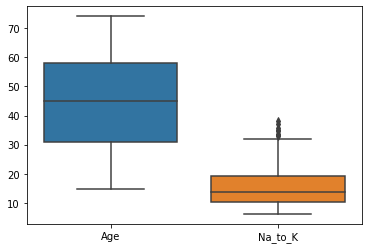

In [ ]:
sns.boxplot(data=df)
plt.show()

In [ ]:
def outliers(data, col):
    Q1=data[col].quantile(0.25)
    Q3=data[col].quantile(0.75)
    IQR=Q3-Q1
    #lower bound is Quartile1-(1.5*IQR)
    lb=Q1-1.5*IQR
    # upper bound is Quartile3+(1.5*IQR)
    ub=Q3+1.5*IQR
    # returning outlier data
    return data[ (data[col]<lb) | (data[col]>ub) ]

In [ ]:
for col in num_col:
    print( col)
    print(outliers(df, col))
    print("\n")

Age
Empty DataFrame
Columns: [Age, Sex, BP, Cholesterol, Na_to_K, Drug]
Index: []


Na_to_K
     Age Sex    BP Cholesterol  Na_to_K   Drug
24    33   F   LOW        HIGH   33.486  DrugY
96    58   F   LOW        HIGH   38.247  DrugY
98    20   M  HIGH      NORMAL   35.639  DrugY
128   47   M   LOW      NORMAL   33.542  DrugY
131   52   M   LOW      NORMAL   32.922  DrugY
184   18   F  HIGH        HIGH   37.188  DrugY
188   65   M  HIGH      NORMAL   34.997  DrugY
194   46   F  HIGH        HIGH   34.686  DrugY




We see their are 8 outlier values in Na_to_K column. Now lets see how is this variable related to our target column

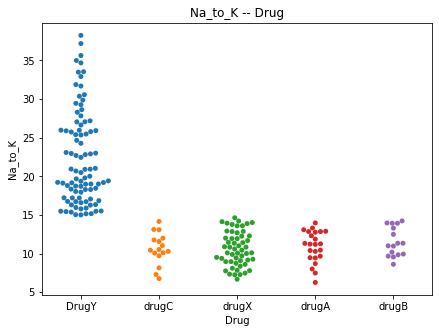

In [ ]:
plt.figure(figsize = (7,5))
sns.swarmplot(x = "Drug", y = "Na_to_K",data = df)
plt.title("Na_to_K -- Drug")
plt.show()

People who have Na_to_K ratio bigger than 15.015, get DrugY. We can create a new feature from here.



In [ ]:
df['Na_to_K_Bigger_Than_15'] = [1 if i >=15.015 else 0 for i in df.Na_to_K]
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Na_to_K_Bigger_Than_15
0,23,F,HIGH,HIGH,25.355,DrugY,1
1,47,M,LOW,HIGH,13.093,drugC,0
2,47,M,LOW,HIGH,10.114,drugC,0
3,28,F,NORMAL,HIGH,7.798,drugX,0
4,61,F,LOW,HIGH,18.043,DrugY,1


In [ ]:
df_NaK15 = df.groupby(["Drug","Na_to_K_Bigger_Than_15"]).size().reset_index(name = "Count")
df_NaK15

,Drug,Na_to_K_Bigger_Than_15,Count
0,DrugY,1,91
1,drugA,0,23
2,drugB,0,16
3,drugC,0,16
4,drugX,0,54


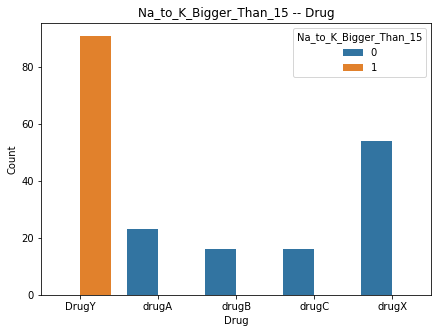

In [ ]:
plt.figure(figsize = (7,5))
sns.barplot(x = "Drug",y="Count", hue = "Na_to_K_Bigger_Than_15",data = df_NaK15)
plt.title("Na_to_K_Bigger_Than_15 -- Drug")
plt.show()

Na_to_K_Bigger_Than_15 feature will be important feature to drugY classification.



#2. Categorical Variables

In [ ]:
cat_col=[col for col in df.columns if df[col].dtypes=='O' ]
cat_col   

['Sex', 'BP', 'Cholesterol', 'Drug']

In [ ]:
for col in cat_col:
  print(col)
  print(df[col].value_counts())
  print()

Sex
M    104
F     96
Name: Sex, dtype: int64

BP
HIGH      77
LOW       64
NORMAL    59
Name: BP, dtype: int64

Cholesterol
HIGH      103
NORMAL     97
Name: Cholesterol, dtype: int64

Drug
DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64



It can be seen that from results above, DrugY has more amount than other types of drugs, so the data is imbalanced and we would need to treat this later

#Visualizations

Age Distribution

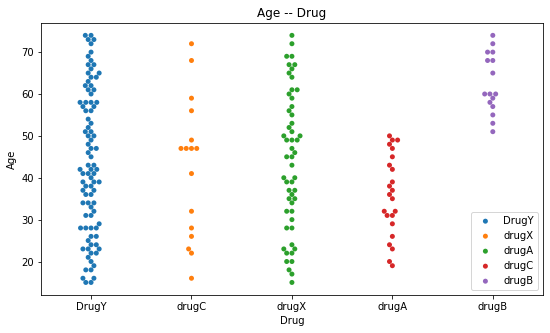

In [ ]:
plt.figure(figsize = (9,5))
sns.swarmplot(x = "Drug", y = "Age",data = df)
plt.legend(df.Drug.value_counts().index)
plt.title("Age -- Drug")
plt.show()

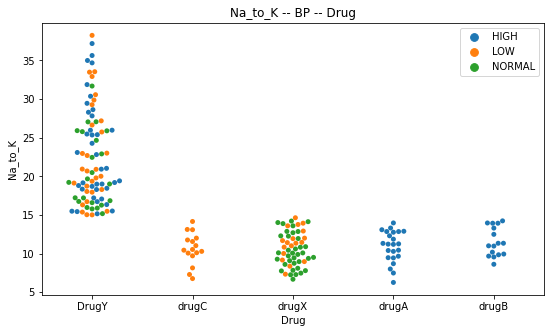

In [ ]:
plt.figure(figsize = (9,5))
sns.swarmplot(x = "Drug", y = "Na_to_K",hue="BP",data = df)
plt.legend()
plt.title("Na_to_K -- BP -- Drug")
plt.show()

If people have HIGH blood pressure and Na_to_K ratio is lower than 15 , they get drugA and drugB only.
If people have LOW blood pressure and Na_to_K ratio is lower than 15 , they get drugC only.

Gender Distribution

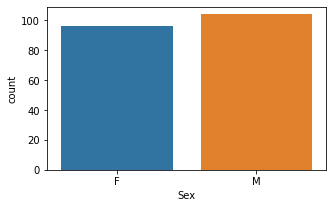

In [ ]:
plt.figure(figsize=(5,3))
sns.countplot(x = df.Sex)
plt.show()

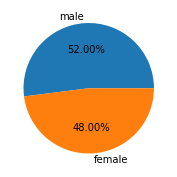

In [ ]:
plt.figure(figsize=(5,3))
keys=['male','female']
plt.pie(df['Sex'].value_counts(),labels=keys,autopct='%.2f%%')
plt.show()

1. The ratio of gender seems balanced in the data
2. This is a categorical variable. We will apply label encoder to avoid any error during model implementation.

Gender Distribution based on Drug Type

In [ ]:
pd.crosstab(df.Sex,df.Drug)

Drug,DrugY,drugA,drugB,drugC,drugX
Sex,,,,,
F,47,9,6,7,27
M,44,14,10,9,27


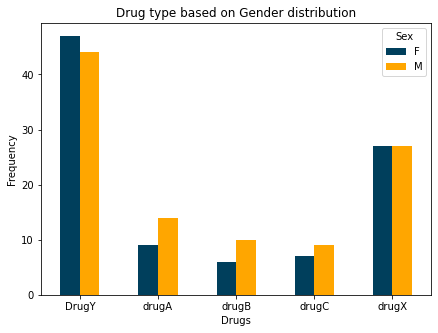

In [ ]:
pd.crosstab(df.Drug,df.Sex).plot(kind="bar",figsize=(7,5),color=['#003f5c','#ffa600','#58508d','#bc5090','#ff6361'])
plt.title('Drug type based on Gender distribution')
plt.xlabel('Drugs')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

1. Here we can see that both male and female take Drug Y the most
2. Male take drugA, drugB and drugC more than femmale.
3. Female get DrugY more than male.
4. drugX seems equal for male and female people.
5. According to this graph, Sex feature is not an important feature for classification.

Blood Pressure Distribution

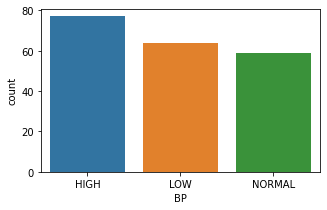

In [ ]:
plt.figure(figsize = (5,3))
sns.countplot(df.BP)
plt.show()

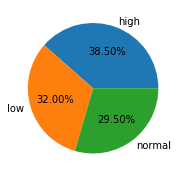

In [ ]:
plt.figure(figsize = (5,3))
keys=['high','low','normal']
plt.pie(df['BP'].value_counts(),labels=keys,autopct='%.2f%%')
plt.show()

1. The ratio of BP seems balanced in the data
2. This is a categorical variable. We will apply label encoder to avoid any error during model implementation.

Drug type distribution based on BP

In [ ]:
pd.crosstab(df.BP,df.Drug)

Drug,DrugY,drugA,drugB,drugC,drugX
BP,,,,,
HIGH,38,23,16,0,0
LOW,30,0,0,16,18
NORMAL,23,0,0,0,36


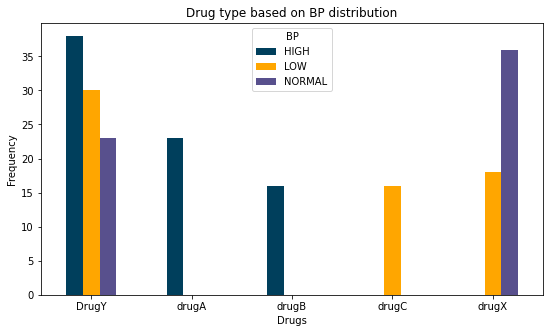

In [ ]:
pd.crosstab(df.Drug,df.BP).plot(kind="bar",figsize=(9,5),color=['#003f5c','#ffa600','#58508d'])
plt.title('Drug type based on BP distribution')
plt.xlabel('Drugs')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

1. drugA and drugB are taken only by people who have HIGH blood pressure.
2. drugC is taken only by people who have LOW blood pressure.
3. drugX is taken by people who have low BP and Normal BP.
4. drugY is taken by all 

By Graph, we can say that BP is an important feature for classification.

Cholesterol Distribution

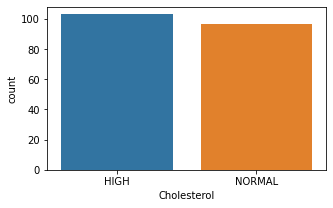

In [ ]:
plt.figure(figsize = (5,3))
sns.countplot(df.Cholesterol)
plt.show()

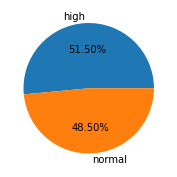

In [ ]:
plt.figure(figsize = (5,3))
keys=['high','normal']
plt.pie(df['Cholesterol'].value_counts(),labels=keys,autopct='%.2f%%')
plt.show()

1. The ratio of cholestrol seems balanced in the data
2. This is a categorical variable. We will apply label encoder to avoid any error during model implementation.

Drug Type Distribution Based on Cholestrol

In [ ]:
pd.crosstab(df.Drug,df.Cholesterol)

Cholesterol,HIGH,NORMAL
Drug,,
DrugY,47,44
drugA,12,11
drugB,8,8
drugC,16,0
drugX,20,34


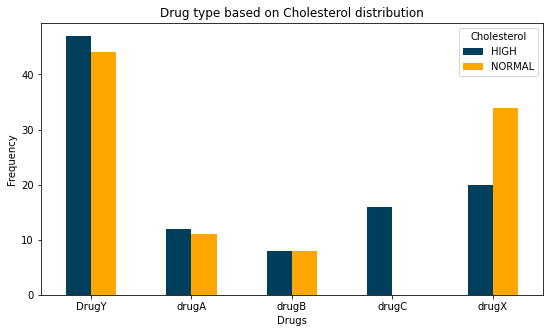

In [ ]:
pd.crosstab(df.Drug,df.Cholesterol).plot(kind="bar",figsize=(9,5),color=['#003f5c','#ffa600','#58508d','#bc5090','#ff6361'])
plt.title('Drug type based on Cholesterol distribution')
plt.xlabel('Drugs')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

1. drugC is got by people who have HIGH cholesterol only.
2. Cholesterol is an important feature to classify drugC

DrugB is taken only by older than 51 years old.
DrugA is taken only by younger than 50 years old.

Drug Type Distribution

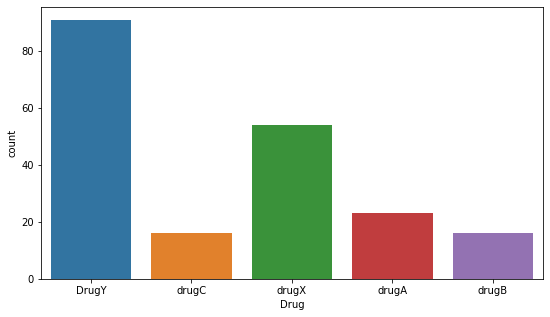

In [ ]:
plt.figure(figsize = (9,5))
sns.countplot(df.Drug)
plt.show()

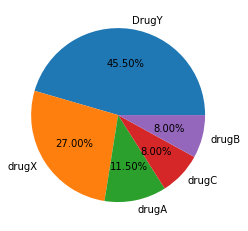

In [ ]:
keys=['DrugY','drugX','drugA','drugC','drugB']
plt.pie(df['Drug'].value_counts(),labels=keys,autopct='%.2f%%')
plt.show()

# Label Encoding

We will convert from object to int64

Sex,
BP,
Cholesterol,
Na_to_K


In [ ]:
from sklearn.preprocessing import LabelEncoder

def label_encoder(y):
    le = LabelEncoder()
    df[y] = le.fit_transform(df[y])

In [ ]:
label_list = ["BP","Cholesterol","Na_to_K","Na_to_K_Bigger_Than_15","Drug"]

for l in label_list:
    label_encoder(l)

In [ ]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Na_to_K_Bigger_Than_15
0,23,F,0,0,167,0,1
1,47,M,1,0,89,3,0
2,47,M,1,0,43,3,0
3,28,F,2,0,10,4,0
4,61,F,1,0,133,0,1


One Hot Encoding : on non ordinal data

In [ ]:
df = pd.get_dummies(df, drop_first = True)

In [ ]:
df.head()

,Age,BP,Cholesterol,Na_to_K,Drug,Na_to_K_Bigger_Than_15,Sex_M
0,23,0,0,167,0,1,0
1,47,1,0,89,3,0,1
2,47,1,0,43,3,0,1
3,28,2,0,10,4,0,0
4,61,1,0,133,0,1,0


In [ ]:
from sklearn.model_selection import train_test_split

x = df.drop(["Drug"],axis=1)
y = df.Drug

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.33, random_state = 1)

In [ ]:
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (134, 6)
x_test shape: (66, 6)
y_train shape: (134,)
y_test shape: (66,)


# Fix Imbalance Data

In [ ]:
smote = SMOTE()

In [ ]:
x_train , y_train = smote.fit_resample(x_train , y_train)

#Model implementation

# 1.Logistic Regression

In [ ]:
lr = LogisticRegression()

In [ ]:
lr.fit(x_train , y_train)

LogisticRegression()

In [ ]:
prediction_test = lr.predict(x_test)

In [ ]:
prediction_train = lr.predict(x_train)

In [ ]:
lrac_train=accuracy_score(y_test , prediction_test)

In [ ]:
lrac_test=accuracy_score(y_train , prediction_train)

In [ ]:
print(classification_report(y_test , prediction_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.71      0.83      0.77         6
           2       0.67      0.67      0.67         6
           3       1.00      0.75      0.86         4
           4       0.96      1.00      0.98        22

    accuracy                           0.92        66
   macro avg       0.87      0.84      0.85        66
weighted avg       0.93      0.92      0.92        66



In [ ]:
print(classification_report(y_train , prediction_train))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       1.00      1.00      1.00        63
           2       0.98      1.00      0.99        63
           3       0.86      0.98      0.92        63
           4       0.98      0.84      0.91        63

    accuracy                           0.96       315
   macro avg       0.97      0.96      0.96       315
weighted avg       0.97      0.96      0.96       315



In [ ]:
print(confusion_matrix(y_test, prediction_test))

[[27  0  0  0  1]
 [ 0  5  1  0  0]
 [ 0  2  4  0  0]
 [ 0  0  1  3  0]
 [ 0  0  0  0 22]]


# 3.K Neighbours



In [ ]:
KNclassifier = KNeighborsClassifier()
KNclassifier.fit(x_train, y_train)
y_pred_test = KNclassifier.predict(x_test)
y_pred_train = KNclassifier.predict(x_train)
print(classification_report(y_test, y_pred_test))
print(classification_report(y_train, y_pred_train))
print()
print(confusion_matrix(y_test, y_pred_test))
print()
KNAcc_test = accuracy_score(y_pred_test,y_test)
KNAcc_train = accuracy_score(y_pred_test,y_test)
print()


              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.10      0.17      0.12         6
           2       0.30      0.50      0.37         6
           3       0.08      0.25      0.12         4
           4       0.57      0.18      0.28        22

    accuracy                           0.55        66
   macro avg       0.41      0.41      0.38        66
weighted avg       0.66      0.55      0.56        66

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.80      0.83      0.81        63
           2       0.85      0.97      0.90        63
           3       0.79      0.84      0.82        63
           4       0.82      0.63      0.71        63

    accuracy                           0.85       315
   macro avg       0.85      0.85      0.85       315
weighted avg       0.85      0.85      0.85       315


[[27  0  1  0  0]
 [ 

In [ ]:
grid = {'n_neighbors':np.arange(1,120),
        'p':np.arange(1,3),
        'weights':['uniform','distance']
       }

knn = KNeighborsClassifier(algorithm = "auto")
knn_cv = GridSearchCV(knn,grid,cv=5)
knn_cv.fit(x_train,y_train)

print("Hyperparameters:",knn_cv.best_params_)
print("Train Score:",knn_cv.best_score_)
print("Test Score:",knn_cv.score(x_test,y_test))


Hyperparameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Train Score: 0.8539682539682539
Test Score: 0.6212121212121212


In [ ]:
KNclassifier = KNeighborsClassifier(n_neighbors= 5, p= 1, weights= 'distance')
KNclassifier.fit(x_train, y_train)
y_pred_test = KNclassifier.predict(x_test)
y_pred_train = KNclassifier.predict(x_train)
print(classification_report(y_test, y_pred_test))
print(classification_report(y_train, y_pred_train))
print()
print(confusion_matrix(y_test, y_pred_test))
print()
KNAcc_gs_test = accuracy_score(y_pred_test,y_test)
KNAcc_gs_train= accuracy_score(y_pred_test,y_test)
print()
print(confusion_matrix(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.25      0.33      0.29         6
           2       0.30      0.50      0.37         6
           3       0.15      0.50      0.24         4
           4       0.75      0.27      0.40        22

    accuracy                           0.61        66
   macro avg       0.49      0.51      0.46        66
weighted avg       0.73      0.61      0.62        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        63
           2       1.00      1.00      1.00        63
           3       1.00      1.00      1.00        63
           4       1.00      1.00      1.00        63

    accuracy                           1.00       315
   macro avg       1.00      1.00      1.00       315
weighted avg       1.00      1.00      1.00       315


[[27  0  1  0  0]
 [ 

# 4.RandomForestClassifier

In [ ]:
RFclassifier = RandomForestClassifier()
RFclassifier.fit(x_train, y_train)
y_pred_test = RFclassifier.predict(x_test)
y_pred_train = RFclassifier.predict(x_train)
print(classification_report(y_test, y_pred_test))
print(classification_report(y_train, y_pred_train))
print()
print(confusion_matrix(y_test, y_pred_test))
print()
RFAcc_test = accuracy_score(y_pred_test,y_test)
RFAcc_train = accuracy_score(y_pred_train,y_train)
print()
print(confusion_matrix(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       0.75      1.00      0.86         6
           2       1.00      0.67      0.80         6
           3       1.00      0.75      0.86         4
           4       0.96      1.00      0.98        22

    accuracy                           0.95        66
   macro avg       0.94      0.88      0.90        66
weighted avg       0.96      0.95      0.95        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        63
           2       1.00      1.00      1.00        63
           3       1.00      1.00      1.00        63
           4       1.00      1.00      1.00        63

    accuracy                           1.00       315
   macro avg       1.00      1.00      1.00       315
weighted avg       1.00      1.00      1.00       315


[[28  0  0  0  0]
 [ 

In [ ]:
grid = {'n_estimators':[85,100],'min_samples_split':[15,20],'max_depth':[8,10],
        'criterion':['gini','entropy']
       }

rf = RandomForestClassifier(random_state = 42)
rf_cv = GridSearchCV(rf,grid,cv=5)
rf_cv.fit(x_train,y_train)

print("Hyperparameters:",rf_cv.best_params_)
print("Train Score:",rf_cv.best_score_)
print("Test Score:",rf_cv.score(x_test,y_test))

Hyperparameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 15, 'n_estimators': 85}
Train Score: 0.9587301587301587
Test Score: 0.9393939393939394


In [ ]:
RFclassifier = RandomForestClassifier(criterion= 'entropy', max_depth= 8, min_samples_split= 20, n_estimators= 85)
RFclassifier.fit(x_train, y_train)
y_pred_test = RFclassifier.predict(x_test)
y_pred_train = RFclassifier.predict(x_train)
print(classification_report(y_test, y_pred_test))
print(classification_report(y_train, y_pred_train))
print()
print(confusion_matrix(y_test, y_pred_test))
print()
RFAcc_gs_test= accuracy_score(y_pred_test,y_test)
RFAcc_gs_train= accuracy_score(y_pred_train,y_train)
print()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       0.75      1.00      0.86         6
           2       1.00      0.67      0.80         6
           3       1.00      0.50      0.67         4
           4       0.92      1.00      0.96        22

    accuracy                           0.94        66
   macro avg       0.93      0.83      0.86        66
weighted avg       0.95      0.94      0.93        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        63
           2       1.00      1.00      1.00        63
           3       0.89      0.98      0.93        63
           4       0.98      0.87      0.92        63

    accuracy                           0.97       315
   macro avg       0.97      0.97      0.97       315
weighted avg       0.97      0.97      0.97       315


[[28  0  0  0  0]
 [ 

#7.SVM Classifier RBF

In [ ]:
svclassifier=SVC(kernel='rbf')
svclassifier.fit(x_train,y_train)
y_pred_test=svclassifier.predict(x_test)
y_pred_train=svclassifier.predict(x_train)
print(classification_report(y_test,y_pred_test))
print(classification_report(y_train,y_pred_train))
svcrbf_train= accuracy_score(y_pred_test,y_test)
svcrbf_test= accuracy_score(y_pred_train,y_train)
print(confusion_matrix(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.20      0.33      0.25         6
           2       0.27      0.50      0.35         6
           3       0.07      0.25      0.11         4
           4       0.50      0.09      0.15        22

    accuracy                           0.53        66
   macro avg       0.41      0.43      0.37        66
weighted avg       0.64      0.53      0.53        66

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        63
           1       0.49      0.54      0.52        63
           2       0.75      0.92      0.83        63
           3       0.62      0.79      0.69        63
           4       0.62      0.29      0.39        63

    accuracy                           0.70       315
   macro avg       0.70      0.70      0.68       315
weighted avg       0.70      0.70      0.68       315

[[27  0  1  0  0]
 [ 0

#8. SVM Classifier Sigmoid

In [ ]:
svclassifier=SVC(kernel='sigmoid')
svclassifier.fit(x_train,y_train)
y_pred_test=svclassifier.predict(x_test)
y_pred_train=svclassifier.predict(x_train)
print(classification_report(y_test,y_pred_test))
print(classification_report(y_train,y_pred_train))
svcsig_train= accuracy_score(y_pred_test,y_test)
svcsig_test= accuracy_score(y_pred_train,y_train)
print(confusion_matrix(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00         6
           2       0.50      0.33      0.40         6
           3       0.00      0.00      0.00         4
           4       0.33      0.05      0.08        22

    accuracy                           0.05        66
   macro avg       0.17      0.08      0.10        66
weighted avg       0.16      0.05      0.06        66

              precision    recall  f1-score   support

           0       0.04      0.10      0.05        63
           1       0.32      0.10      0.15        63
           2       0.65      0.24      0.35        63
           3       0.00      0.00      0.00        63
           4       0.65      0.17      0.28        63

    accuracy                           0.12       315
   macro avg       0.33      0.12      0.16       315
weighted avg       0.33      0.12      0.16       315

[[ 0  1  0 27  0]
 [ 5

#9.SVM Poly

In [ ]:
svclassifier=SVC(kernel='poly')
svclassifier.fit(x_train,y_train)
y_pred_test=svclassifier.predict(x_test)
y_pred_train=svclassifier.predict(x_train)
print(classification_report(y_test,y_pred_test))
print(classification_report(y_train,y_pred_train))
svcpoly_train= accuracy_score(y_pred_test,y_test)
svcpoly_test= accuracy_score(y_pred_train,y_train)
print(confusion_matrix(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       0.23      0.50      0.32         6
           2       0.42      0.83      0.56         6
           3       0.09      0.25      0.13         4
           4       0.00      0.00      0.00        22

    accuracy                           0.56        66
   macro avg       0.35      0.52      0.40        66
weighted avg       0.49      0.56      0.51        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       0.49      0.84      0.62        63
           2       0.81      0.89      0.85        63
           3       0.58      0.44      0.50        63
           4       0.48      0.21      0.29        63

    accuracy                           0.68       315
   macro avg       0.67      0.68      0.65       315
weighted avg       0.67      0.68      0.65       315

[[28  0  0  0  0]
 [ 0

# 2.Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTclassifier = DecisionTreeClassifier()
DTclassifier.fit(x_train, y_train)
y_pred_test = DTclassifier.predict(x_test)
y_pred_train = DTclassifier.predict(x_train)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))
print()
DTAcc_train = accuracy_score(y_pred_test,y_test)
DTAcc_test= accuracy_score(y_pred_train,y_train)
print()
print(confusion_matrix(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        63
           2       1.00      1.00      1.00        63
           3       1.00      1.00      1.00        63
           4       1.00      1.00      1.00        63

    accuracy                           1.00       315
   macro avg       1.00      1.00      1.00       315
weighted avg       1.00      1.00      1.00       315

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.75      1.00      0.86         6
           2       1.00      0.67      0.80         6
           3       1.00      0.75      0.86         4
           4       0.92      1.00      0.96        22

    accuracy                           0.94        66
   macro avg       0.93      0.88      0.89        66
weighted avg       0.95      0.94      0.94        66



[[27  0  0  0  1]
 [

#Model Comparison

In [ ]:
compare = pd.DataFrame({'Model': ['Logistic Regression test', ' Decision Tree test',' K neighbours test',' K neighbours Grid Search test',' Random Forest test',' Random Forest Grid Search test','SVM rbf test','SVM Sigmoid test','SVM Poly test'], 'Accuracy': [lrac_test*100, DTAcc_test*100,KNAcc_test*100,KNAcc_gs_test*100,RFAcc_test*100,RFAcc_gs_test*100,svcrbf_test*100,svcsig_test*100,svcpoly_test*100] })
compare.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
1,Decision Tree test,100.000000
0,Logistic Regression test,96.190476
4,Random Forest test,95.454545
5,Random Forest Grid Search test,93.939394
6,SVM rbf test,69.523810
8,SVM Poly test,67.619048
3,K neighbours Grid Search test,60.606061
2,K neighbours test,54.545455
7,SVM Sigmoid test,12.063492


In [ ]:
compare = pd.DataFrame({'Model': ['Logistic Regression train', ' Decision Tree train',' K neighbours train',' K neighbours Grid Search train',' Random Forest train',' Random Forest GS train','SVM rbf train','SVM Sigmoid train','SVM Poly train'], 'Accuracy': [lrac_train*100, DTAcc_train*100,KNAcc_train*100,KNAcc_gs_train*100,RFAcc_train*100,RFAcc_gs_train*100,svcrbf_train*100,svcsig_train*100,svcpoly_train*100] })
compare.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
4,Random Forest train,100.000000
5,Random Forest GS train,97.142857
1,Decision Tree train,93.939394
0,Logistic Regression train,92.424242
3,K neighbours Grid Search train,60.606061
8,SVM Poly train,56.060606
2,K neighbours train,54.545455
6,SVM rbf train,53.030303
7,SVM Sigmoid train,4.545455


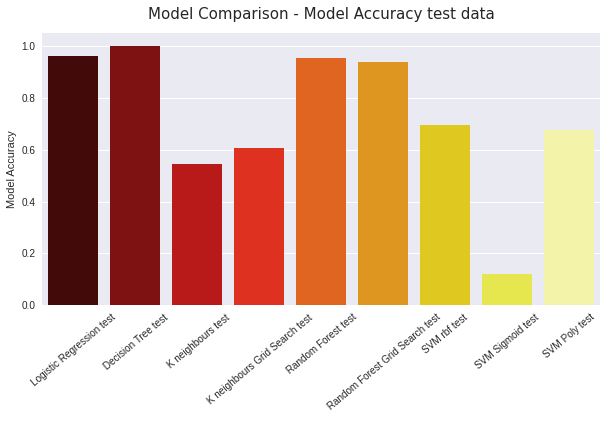

In [ ]:
plt.style.use("seaborn")

x = ['Logistic Regression test', ' Decision Tree test',' K neighbours test',' K neighbours Grid Search test',' Random Forest test',' Random Forest Grid Search test','SVM rbf test','SVM Sigmoid test','SVM Poly test']

y = [lrac_test, DTAcc_test,KNAcc_test,KNAcc_gs_test,RFAcc_test,RFAcc_gs_test, svcrbf_test,svcsig_test,svcpoly_test]

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=x,y=y, palette="hot");
plt.ylabel("Model Accuracy")
plt.xticks(rotation=40)
plt.title("Model Comparison - Model Accuracy test data", fontsize=15, fontname="Helvetica", y=1.03);

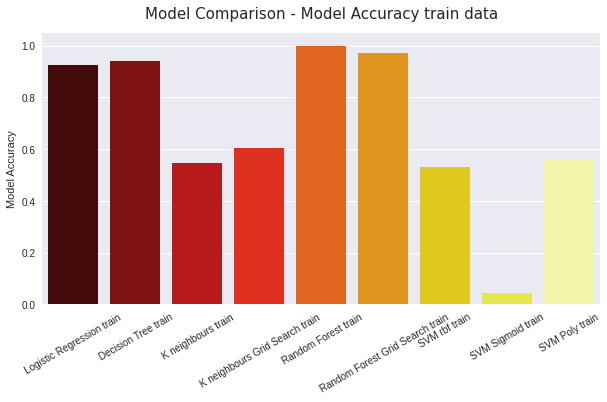

In [ ]:
plt.style.use("seaborn")

x = ['Logistic Regression train', ' Decision Tree train',' K neighbours train',' K neighbours Grid Search train',' Random Forest train',' Random Forest Grid Search train','SVM rbf train','SVM Sigmoid train','SVM Poly train']

y = [lrac_train, DTAcc_train,KNAcc_train,KNAcc_gs_train,RFAcc_train,RFAcc_gs_train, svcrbf_train,svcsig_train,svcpoly_train]

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=x,y=y, palette="hot");
plt.ylabel("Model Accuracy")
plt.xticks(rotation=30)
plt.title("Model Comparison - Model Accuracy train data", fontsize=15, fontname="Helvetica", y=1.03);

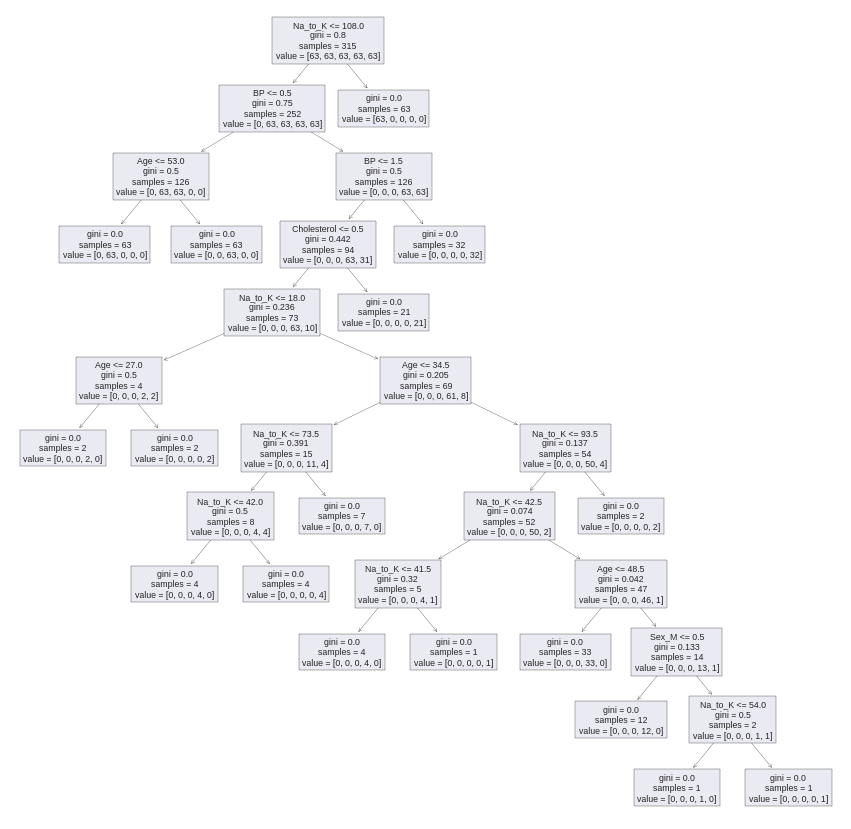

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15,15))
_=plot_tree(DTclassifier, 
                   feature_names=x_train.columns,  
)